## 1. Implementation of the k-Nearest Neighbours (kNN) classifier and Cross-Validation

Implementation of kNN and cross validation from scratch. The purpose is to fully understand these algorithmswithout using any library such as scikit-learn that already has kNN or cross validation implemented.

## 1.1 Implementation of the k-Nearest Neighbours classifier



The kNN classifier mainly consists of two stages:

1.   During training, the classifier takes the training data and stores it.
2.   During testing, kNN classifies every test example $x$ by 

> i) finding the $k$ training examples that are most similar to $x$;

> ii) outputing the most common label among these $k$ examples.

To measure the similarity between samples the Euclidean distance is used. The Euclidean distance (a.k.a. $L_2$ distance) between two examples $p$ and $q$ in an $n$-dimensional space is defined as the square root of:

\begin{equation}
(p_1-q_1)^2 + (p_2-q_2)^2 + ... + (p_n-q_n)^2. \tag{1}
\end{equation}

This term is equal to 
\begin{equation}
\sum_i p_i^2 + \sum_i q_i^2 - 2 \sum_i p_i q_i. \tag{2}
\end{equation}


With Euclidean distance, the smaller the value, the more similar the two examples are.

In [1]:
# set up code for this experiment
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1)

In [2]:
def my_euclidean_dist(X_test, X_train):
    """
    Compute the *squared* distance between each test example and each training example

    Input:
    - X_test: A numpy array of shape (num_test, dim_feat) containing test data
    - X_train: A numpy array of shape (num_train, dim_feat) containing training data

    Output:
    - dists: A numpy array of shape (num_test, num_train) where 
           dist[i, j] is the squared Euclidean distance between 
           the i-th test example and the j-th training example
    """
    num_test = X_test.shape[0]
    num_train = X_train.shape[0]
    dists = np.zeros((num_test, num_train))

    # Compute the squared L2 distance between all test and training examples.
    a = np.zeros([num_test])
    b = np.zeros([num_train])
    for i in range(0, num_test):
        a[i] = np.sum(np.square(X_test[i]))

    for j in range(0, num_train):
        b[j] = np.sum(np.square(X_train[j]))

    for i in range(0, num_test):
        for j in range(0, num_train):
            dists[i,j] = a[i] + b[j] - 2*np.dot(X_test[i], X_train[j])

    return dists


To avoid using loops Equation (2) can be formulated with linear algebra.  The trick is to reformulate the L2 distance as two broadcast sums and matrix multiplication.  

In [3]:
def euclidean_dist(X_test, X_train):
    dists = np.add(np.sum(X_test ** 2, axis=1, keepdims=True), np.sum(X_train ** 2, axis=1, keepdims=True).T) - 2* X_test @ X_train.T
    return dists

Once distances are calculated, we can find the top $k$ nearest neighbors for each test example by retrieving from the dists matrix. 
In particular, for each test example $x$, we can sort all the training examples by their distance to $x$ then find the $k$ most nearest neighbors.  

In [8]:
def find_k_neighbors(dists, Y_train, k):
    """
    find the labels of the top k nearest neighbors

    Inputs:
    - dists: distance matrix of shape (num_test, num_train)
    - Y_train: A numpy array of shape (num_train) containing ground true labels for training data
    - k: An integer, k nearest neighbors

    Output:
    - neighbors: A numpy array of shape (num_test, k), where each row containts the 
               labels of the k nearest neighbors for each test example
    """
    # find the top k nearest neighbors for each test sample. Retrieve the corresponding labels of those neighbors.

    num_test = dists.shape[0]
    neighbors = np.zeros((num_test, k), dtype=int)

    for i in range(0, num_test):
        idx = np.argsort(dists[i])
        neighbors[i] = Y_train[np.array(idx[:k])]

    return neighbors

Both functions, `euclidean_dist` and `find_k_neighbors`, can be put together so that labels can be predicted for test examples.  In kNN, the most common label of the $k$ nearest neighbors are found and assign to the test sample.

In [10]:
def knn_predict(X_test, X_train, Y_train, k):
    """
    predict labels for test data.

    Inputs:
    - X_test: A numpy array of shape (num_test, dim_feat) containing test data.
    - X_train: A numpy array of shape (num_train, dim_feat) containing training data.
    - Y_train: A numpy array of shape (num_train) containing ground true labels for training data
    - k: An integer, k nearest neighbors

    Output:
    - Y_pred: A numpy array of shape (num_test). Predicted labels for the test data.
    """
    # find the labels of k nearest neighbors for each test example, and then find the majority label out of the k labels

    num_test = X_test.shape[0]

    dists = euclidean_dist(X_test, X_train)
    neighbors = find_k_neighbors(dists, Y_train, k)
    Y_pred = np.zeros(num_test, dtype=int)

    for i in range(0, num_test):
        values, counts = np.unique(neighbors[i], return_counts=True)
        idx = np.where(counts == max(counts))
        Y_pred[i] = values[idx[0][0]]

    return Y_pred

Next function compares the predicted labels against the true label and compute the error rate in percentage.

In [11]:
def compute_error_rate(ypred, ytrue):
    """
    Compute error rate given the predicted results and true label.
    Inputs:
    - ypred: array of prediction results.
    - ytrue: array of true labels.
    ypred and ytrue should be of same length.
    Output:
    - error rate: float number indicating the error in percentage
    """
    err = 0
    num_test = ypred.shape[0]
    for i in range(num_test):
        err = err + (ypred[i] != ytrue[i])
    error_rate = err / num_test * 100
    #error_rate = np.mean(np.logical_xor(ypred, ytrue)) * 100
    
    return error_rate

## 1.2 Splitting training data for cross validation

Cross validation is a technique in which we train the model using a subset of the available dataset and then evaluate using the complementary subset of the data. We evenly partition the dataset into $n$ mutually disjoint subsets (a.k.a. _folds_). We train an ML model on all but one subset (i.e., train on the union of $n-1$ folds), and then evaluate the model on the subset that was left out.  The former is called _training subset_, while the latter is called _validation subset_. This process is repeated $n$ times, with a different subset reserved for evaluation (and excluded from training) each time.

In [12]:
def split_nfold(num_examples, n):
    """
    Split the dataset in to training sets and validation sets.
    Inputs:
    - num_examples: Integer, the total number of examples in the dataset
    - n: number of folds
    Outputs:
    - train_sets: List of lists, where train_sets[i] (i = 0 ... n-1) contains 
                the indices of examples for training
    - validation_sets: List of list, where validation_sets[i] (i = 0 ... n-1) 
                contains the indices of examples for validation
    """
    train_sets = []
    validation_sets = []
    idx = np.random.permutation(num_examples).tolist()
    fold_size = num_examples//n

    for i in range(n):

        start = i*fold_size
        end = start + fold_size

        if i == n-1:
            end = num_examples

        train_set = np.delete(idx, range(start, end), 0).tolist()
        train_sets.append(train_set)

        val_set = idx[start:end] 
        validation_sets.append(val_set)

    return train_sets, validation_sets

The `cross_validation` function will output the cross validation error rate. It will loop over each of the $n$ training/validation partitions in the output of `split_nfold`. Then it will perform training on train_sets[i] and compute the test error on validation_sets[i].  The final cross validation error rate is the average error rate over all partitions. 

To improve generality, `cross_validation` takes as its first input argument a generic _classifier_ function i.e. kNN

In [13]:
def cross_validation(classifier, X, Y, n, *args):
    """
    Perform cross validation for the given classifier, 
      and return the cross validation error rate.
    Inputs:
    - classifier: function of classification method
    - X: A 2-D numpy array of shape (num_train, dim_feat), containing the whole dataset
    - Y: A 1-D numpy array of length num_train, containing the ground-true labels
    - n: number of folds
    - *args: parameters needed by the classifier.
        There is only one parameter (k) for the kNN clasifier. For other classifiers, there may be multiple paramters. 
        To keep this function general, it will use *args for an unspecified number of paramters.
    Output:
    - error_rate: a floating-point number indicating the cross validation error rate
    """
    np.random.seed(1)

    errors = []
    size = X.shape[0]
    train_sets, val_sets = split_nfold(size, n)

    #for i in range(n):
    #  train_index = train_sets[i]
    #  val_index = val_sets[i]

    for (train_index, val_index) in zip(train_sets, val_sets):

        X_train, X_val = X[train_index], X[val_index]

        y_train, y_val = Y[train_index], Y[val_index]

        y_pred = knn_predict(X_val, X_train, y_train, args[0])
        error = compute_error_rate(y_pred, y_val)

        errors.append(error)

    error_rate = np.average(errors)

    return error_rate 

## 2. Application to optical character recognition (OCR) problem

First it will download the MNIST dataset and split the data into trainning and test sets. After running the code, the training data (Xtrain, ytrain) has 10,000 examples, and the test data (Xtest, ytest) also has 10,000 examples.

In [15]:
import os
import gzip

DATA_URL = 'http://yann.lecun.com/exdb/mnist/'

# Download and import the MNIST dataset from Yann LeCun's website.
# Each image is an array of 784 (28x28) float values  from 0 (white) to 1 (black).
def load_data():
    x_tr = load_images('train-images-idx3-ubyte.gz')
    y_tr = load_labels('train-labels-idx1-ubyte.gz')
    x_te = load_images('t10k-images-idx3-ubyte.gz')
    y_te = load_labels('t10k-labels-idx1-ubyte.gz')

    return x_tr, y_tr, x_te, y_te

def load_images(filename):
    maybe_download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 28 * 28) / np.float32(256)

def load_labels(filename):
    maybe_download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

# Download the file, unless it's already here.
def maybe_download(filename):
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        print("Downloading %s" % filename)
        urlretrieve(DATA_URL + filename, filename)

Xtrain, ytrain, Xtest, ytest = load_data()

train_size = 10000
test_size  = 10000

Xtrain = Xtrain[0:train_size]
ytrain = ytrain[0:train_size]

Xtest = Xtest[0:test_size]
ytest = ytest[0:test_size]

## 2.1 Effect of different numbers of training examples

It computes the classification error of the 1-NN ($k=1$) for the MNIST dataset by calling the `knn_predict` function and check if the error changes with different number of training examples. It will train on the **first** $ntr$ number of training examples in (Xtrain, ytrain), where $ntr$ is varied in $\{100, 1000, 2500, 5000, 7500, 10000\}$.
1. Print the test error rate for each of these values of $ntr$ using all 10,000 test examples stored in (Xtest, ytest) for testing.
2. Plot a figure where the $x$-axis is the above values of $ntr$, and the $y$-axis is the test error rate.

Directly calling `knn_predict` with the training and test set may cost too much memory.  So it classifies the test examples in batches, i.e., divide the test set into `nbtaches` number of subsets/batches, and predict for the first batch, then second batch, etc.

#tr = 100, error rate = 32.06%
#tr = 1000, error rate = 13.10%
#tr = 2500, error rate = 8.64%
#tr = 5000, error rate = 6.57%
#tr = 7500, error rate = 5.91%
#tr = 10000, error rate = 5.37%


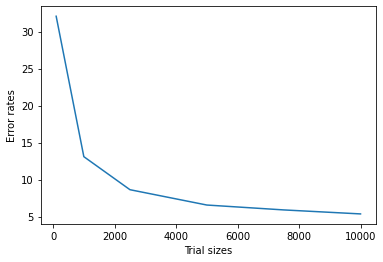

In [16]:
#  nbatches must be an even divisor of test_size. Increase if memmory runs out
if test_size > 1000:
    nbatches = 50
else:
    nbatches = 5

# Let us first set up the index of each batch. 
# After running the next line, 'batches' will be a 2D array sized nbatches-by-m,
# where m = test_size / nbatches.
# batches[i] stores the indices (out of 0...test_size-1) for the i-th batch
# Run 'print(batches[3])' etc to witness the value of 'batches'.
test_size = 10000
batches = np.array_split(np.arange(test_size), nbatches)
ypred = np.zeros_like(ytest)
trial_sizes = [100, 1000, 2500, 5000, 7500, 10000]
trials = len(trial_sizes)
error_rates = [0]*trials
k = 1

for t in range(trials):
    trial_size = trial_sizes[t]
    trial_X = Xtrain[:trial_size]
    trial_Y = ytrain[:trial_size]

    ypred = []
    for i in range(nbatches):
        ypred.extend(knn_predict(Xtest[batches[i]], trial_X, trial_Y, k))
    ypred = np.asarray(ypred)

    error_rates[t] = compute_error_rate(ypred, ytest)
    print(f'#tr = {trial_size}, error rate = {error_rates[t]:.2f}%')

plt.plot( trial_sizes, error_rates)
plt.xlabel('Trial sizes')
plt.ylabel('Error rates')
plt.show()


## 2.2 Effect of different number of cross validation folds

In the following code block, we will perform cross validation on 1-NN classification. I will compute the cross validation error rate for the first **1000** training examples with different number of folds $n \in \{3, 10, 50, 100, 1000\}$. Then **print** the error rate for each different $n$ and **plot** a figure where the $x$-axis is $n = \{3, 10, 50, 100, 1000\}$, and the $y$-axis is the $n$-fold cross validation error rate. 

In the current setting, the **1000** training examples correspond to the _dataset_. In other words, this Section 2.2 will **not** use the test examples loaded from Problem 2, nor the remaining $10000 - 1000 = 9000$ training examples.

3-folds error rate: 12.70%

10-folds error rate: 12.00%

50-folds error rate: 12.10%

100-folds error rate: 11.90%

1000-folds error rate: 11.80%



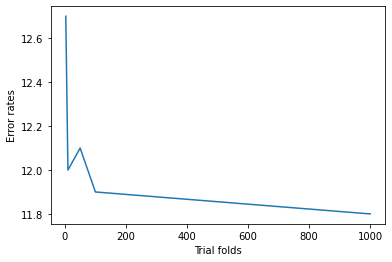

In [17]:

size = 1000
k = 1

cvXtrain = Xtrain[:1000]
cvytrain = ytrain[:1000]

trial_folds = [3, 10, 50, 100, 1000]
trials = len(trial_folds)
cverror_rates = [0]*trials

for t in range(trials):
    error_rate = cross_validation(knn_predict, cvXtrain, cvytrain, trial_folds[t], k)
    cverror_rates[t] = error_rate

    print('{:d}-folds error rate: {:.2f}%\n'.format(trial_folds[t], error_rate)) 

plt.plot( trial_folds, cverror_rates)
plt.xlabel('Trial folds')
plt.ylabel('Error rates')
plt.show()

## 3. Iris plant recognition application

The iris dataset includes 3 iris species of 50 examples each, where each example recorded petal and sepal length. For convenience, we will use the built-in functions in `scikit-learn` library to load dataset and create data partitions. For this experiment, we will use $80\%$ (120) examples for training and $20\%$ (30) for testing. 

In [18]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# loading iris dataset
iris = load_iris()
# split dataset into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=1)

### 3.1 Find the best $k$
The value of $k$ has a considerable impact on the performance of kNN. To determine the best value of this hyperparameter we can use $10$-fold cross-validation.
We will vary $k$ in the range (1, 100) in increments of 1.
Then we will find the best $k$ in terms of the lowest validation error rate. It will also plot a curve that shows the validation error rates as $k$ increases. 

In the current setting, (X_strain, Y_train) loaded above correspond to the _dataset_. In other words, this Section 3.1 will **not** use the test examples loaded above.

Best value of K:  9


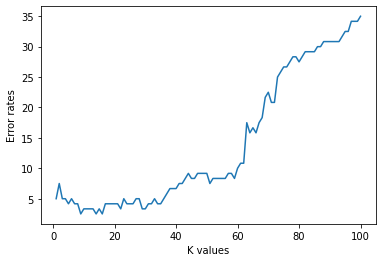

In [19]:
list_ks = list(range(1, 101))
err_ks = np.zeros(100)
for k in list_ks:
    err_ks[k-1] = cross_validation(knn_predict, X_train, Y_train, 10, k)

best_k = np.argmin(err_ks)+1

print('Best value of K: ', best_k)

plt.plot( list_ks, err_ks)
plt.xlabel('K values')
plt.ylabel('Error rates')
plt.show()

### 3.2 Evaluation on test set
With the best hyperparameters for KNN classifier, it's time to evaluate this method on test data.

In [20]:
y_pred = knn_predict(X_test, X_train, Y_train, best_k)
err_test = compute_error_rate(y_pred, Y_test)

print(f'The test error is {err_test:.1f}%')

The test error is 3.3%


### 3.3 F-score measurement
So far we have mainly used classification accuracy to evaluate the performance of our model. As a performance measure, **accuracy is inappropriate for imbalanced classification problems.**
An alternative is the F-score metrics. To do so we will implement the computation of the confusion matrix on test set using `y_test` and the prediction `y_pred` from Section 3.2 and the F1 score manually. Also, report the precision, recall, and F1-score for each class by using the built-in functions from sklearn.


In [21]:
nclass = len(np.unique(Y_test))  # should be 3. Just be more adaptive to data.
cm = np.zeros((nclass, nclass), dtype=int)  # confusion matrix is integer valued

from sklearn.metrics import confusion_matrix, classification_report

def calulate_F1_score(cm, nclass):

    f1_scores = []
    for c in range(nclass):
        TP = cm[c][c]
        precision = TP / (TP + cm.sum(axis=0)[c]- TP)
        recall = TP / (TP + cm.sum(axis=1)[c] - TP)
        f1 = round(2*(precision*recall)/(precision+recall), 2)
        f1_scores.append(f1)
    return f1_scores

nte = X_test.shape[0]
for t in range(nte):
    cm[Y_test[t], y_pred[t]] += 1

skl_cm = confusion_matrix(Y_test, y_pred)
skl_report = classification_report(Y_test, y_pred)

print('Dev Confusion Matrix: \n', cm)
print('Skl Confusion Matrix: \n', skl_cm)
print('Skl report: \n', skl_report)
print('F1 scores: \n', '[c1, c2, c3] = ', calulate_F1_score(cm, nclass))

Dev Confusion Matrix: 
 [[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
Skl Confusion Matrix: 
 [[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
Skl report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.92      0.96        13
           2       0.86      1.00      0.92         6

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30

F1 scores: 
 [c1, c2, c3] =  [1.0, 0.96, 0.92]
